In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import unyt 
from scipy.integrate import trapezoid, quad
from deformation_models import SLS

In [8]:
def stress_steps(tstar): 
    stress_dot_t = stress(tstar)    
    return stress_dot_t[1:] - stress_dot_t[:-1]

def J_signal(solid, t, tstar):
    t_diff = t - tstar
    return solid.J_t(t_diff)[0:-1]

def calc_stress_strain(tmax, dt_max, stress_func, solid, tmin=0.001, n_t=1000):
    t_actual = np.linspace(tmin, tmax, n_t)
    
    stain_vals = []
    stress_vals = []
    stress_i = 0
    for t in t_actual:
        ntstar = int(t / dt_max) + 10
        tstar = np.linspace(tmin, t, ntstar)
        
        f1 = stress_steps(tstar)        
        f2 = J_signal(sls_solid, t, tstar)
        stress_i = np.sum(f1)
        strain_i = np.sum(f1 * f2)
        
        stain_vals.append(strain_i)
        stress_vals.append(stress_i)
    
    strain_vals = np.array(stain_vals)
    stress_vals = np.array(stress_vals)
    
    return strain_vals, stress_vals, t_actual

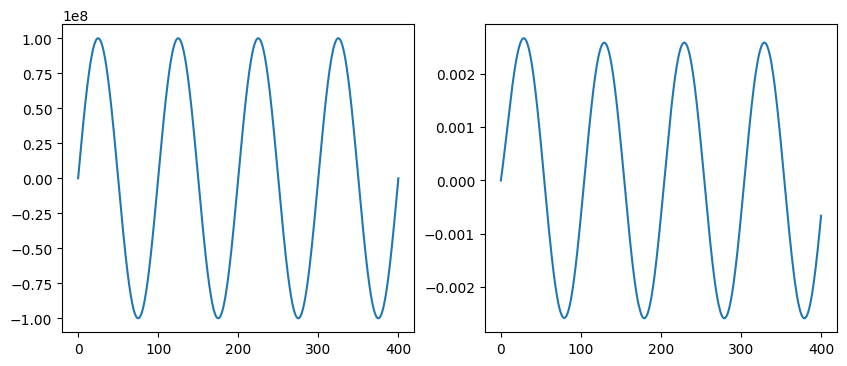

In [52]:
tmax = 100
f_Hz = 1/100.
w = 2 * np.pi * f_Hz
dt_max = 1 / f_Hz / 50
stress_amp = 100 * 1e6

Ju_1 = 1 / (60 * 1e9)
Ju_2 = 1 / (70 * 1e9 )
tau_m = 1e12 * Ju_2 
sls_solid = SLS(Ju_1, tau_m, Ju_2)

def stress(t): 
    return np.sin(t * w) * stress_amp
    
strain_vals, stress_vals, t = calc_stress_strain(400, dt_max, stress, sls_solid, tmin=0.00000001, n_t = int(1e4))

f, axs = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
axs[0].plot(t, stress_vals)
axs[1].plot(t, strain_vals)

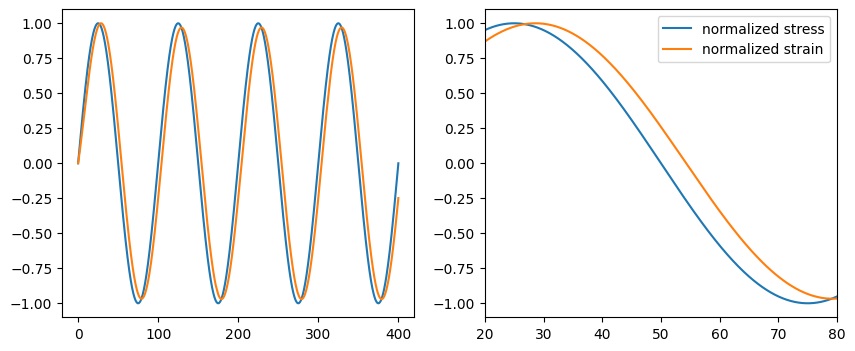

In [53]:
n_strain = strain_vals/strain_vals[t>20].max()
n_stress = stress_vals/stress_vals.max()

f, axs = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
axs[0].plot(t, n_stress, label='normalized stress')
axs[0].plot(t, n_strain, label='normalized strain')

axs[1].plot(t, n_stress, label='normalized stress')
axs[1].plot(t, n_strain, label='normalized strain')

axs[1].set_xlim(20, 80)
axs[1].legend()

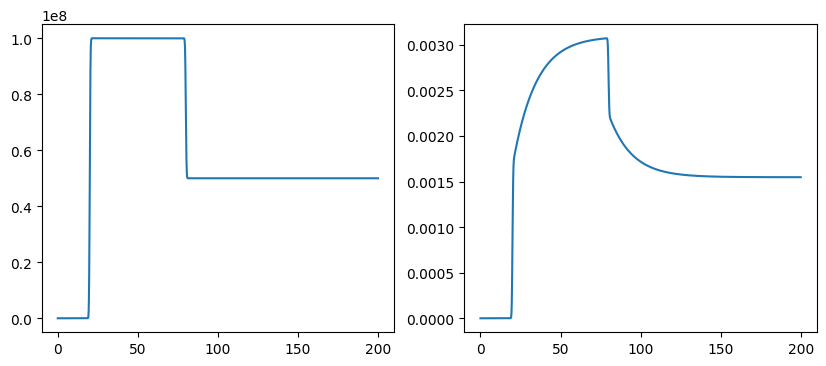

In [54]:
from scipy.special import erf

stress_ramp_time = 0.5
t_stress = 20
t_stress_off = 80
stress_amp = 1e8
dt_max = stress_ramp_time / 10

def stress(t): 
    stress_on = erf((t - t_stress)/stress_ramp_time)
    stress_off = 0.5 * erf((t - t_stress_off)/stress_ramp_time)
    return stress_amp * 0.5 * (1 + stress_on - stress_off)
    
strain_vals, stress_vals, t = calc_stress_strain(200, dt_max, stress, sls_solid, tmin=0.00000001, n_t = int(1e4))

f, axs = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
axs[0].plot(t, stress_vals)
axs[1].plot(t, strain_vals)

In [58]:
%%time
tmax = 100
f_Hz = 1/100.
w = 2 * np.pi * f_Hz
dt_max = 1 / f_Hz / 1000
stress_amp = 100 * 1e6

Ju_1 = 1 / (60 * 1e9)
Ju_2 = 1 / (70 * 1e9 )
tau_m = 1e12 * Ju_2 
sls_solid = SLS(Ju_1, tau_m, Ju_2)

def stress(t): 
    return np.sin(t * w) * stress_amp
    
strain_vals, stress_vals, t = calc_stress_strain(1000, dt_max, stress, sls_solid, tmin=0.00000001, n_t = int(1e4))

CPU times: user 654 ms, sys: 16.2 ms, total: 671 ms
Wall time: 667 ms


In [61]:
from dask import delayed, compute

In [78]:
def stress(t): 
    stress_on = erf((t - t_stress)/stress_ramp_time)
    stress_off = 0.5 * erf((t - t_stress_off)/stress_ramp_time)
    return stress_amp * 0.5 * (1 + stress_on - stress_off)


In [80]:
%%time
for _ in range(10):
    strain_vals, stress_vals, t = calc_stress_strain(1000, dt_max, stress, sls_solid, tmin=0.00000001, n_t = int(1e4))

CPU times: user 9.63 s, sys: 92.7 ms, total: 9.72 s
Wall time: 9.72 s


In [82]:
%%time
results = []
for _ in range(10):
    results.append(delayed(calc_stress_strain)(1000, dt_max, stress, sls_solid, tmin=0.00000001, n_t = int(1e4)))

results = compute(*results)                        

CPU times: user 15 s, sys: 11.4 s, total: 26.4 s
Wall time: 11.2 s


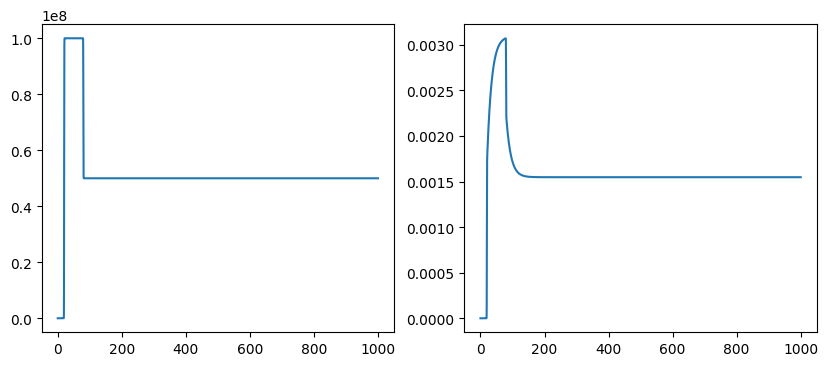

In [75]:
f, axs = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
axs[0].plot(t, stress_vals)
axs[1].plot(t, strain_vals)